In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DistributedSampler, RandomSampler, SequentialSampler


from torchvision import transforms


from pytorchvideo.models import x3d
from pytorchvideo.data import (
    Ucf101, 
    RandomClipSampler, 
    UniformClipSampler, 
    Kinetics,
    SSv2
)


from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
)


#import torchinfo

from tqdm.notebook import tqdm
import itertools
import os
import pickle

In [2]:
class Args:
    def __init__(self):
        self.metadata_path = '/mnt/NAS-TVS872XT/dataset/'
        self.root = self.metadata_path
        self.annotation_path = self.metadata_path
        self.FRAMES_PER_CLIP = 16
        self.STEP_BETWEEN_CLIPS = 16
        self.BATCH_SIZE = 16
        self.NUM_WORKERS = 8  # kinetics:8, ucf101:24

        self.CLIP_DURATION = (8 * 8) / 30  # (num_frames * sampling_rate)/fps
        self.VIDEO_NUM_SUBSAMPLED = 8  # 事前学習済みモデルに合わせて16→8
        self.UCF101_NUM_CLASSES = 101
        self.KINETIC400_NUM_CLASSES = 400

args = Args()

In [3]:
transform = Compose([
    ApplyTransformToKey(
        key="video",
        transform=Compose([
            UniformTemporalSubsample(args.VIDEO_NUM_SUBSAMPLED),
            transforms.Lambda(lambda x: x / 255.),
            # Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
            ShortSideScale(size=256),
            # RandomShortSideScale(min_size=256, max_size=320,),
            # CenterCropVideo(crop_size=(256, 256)),
            CenterCrop(256),
            # RandomCrop(224),
            RandomHorizontalFlip(),
        ]),
    ),
    ApplyTransformToKey(
        key="label",
        transform=transforms.Lambda(lambda x: x),
    ),
    RemoveKey("audio"),
])

In [18]:
root_SSv2 = '/mnt/NAS-TVS872XT/dataset/something-something-v2/'

# train_dataset = SSv2(
#             label_name_file=root_SSv2+"something-something-v2-labels.json",
#             video_label_file=root_SSv2+"something-something-v2-train.json",
#             video_path_label_file=root_SSv2+"PySlowFast/train.csv",
#             video_path_prefix="/tmp/",
#             clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
#             video_sampler=SequentialSampler,
#             # decode_audio=False,
#             transform=transform,
#         )

val_dataset = SSv2(
            label_name_file=root_SSv2+"something-something-v2-labels.json",
            video_label_file=root_SSv2+"something-something-v2-validation.json",
            video_path_label_file=root_SSv2+"PySlowFast/val.csv",
            video_path_prefix="/tmp/",
            clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
            video_sampler=RandomSampler,
            # decode_audio=False,
            transform=transform,
        )


In [19]:
# print(len(train_dataset.video_sampler))
print(len(val_dataset.video_sampler))


24777


In [20]:
data = val_dataset.__next__()

In [21]:
print(data["video"].shape)

torch.Size([3, 8, 256, 256])


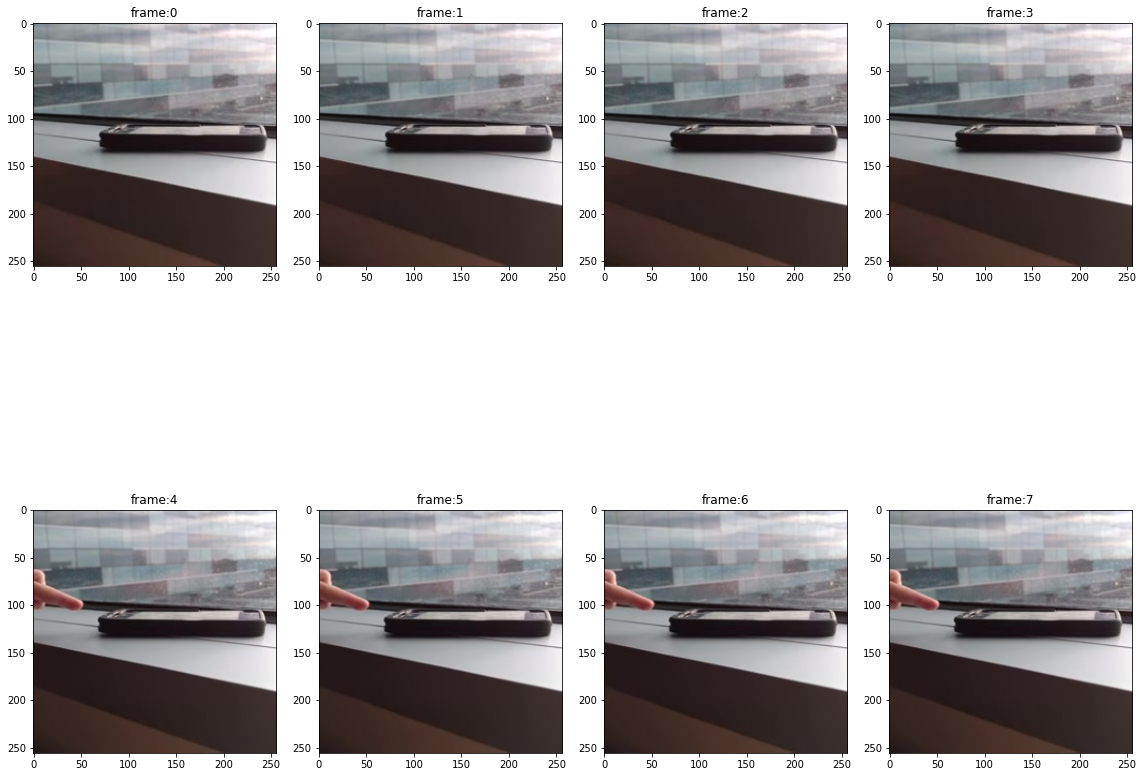

In [22]:
import numpy as np
import matplotlib.pyplot as plt

video = []
frame_list = []

# for i in range(16):
#     video.append(data["video"][i:i+1].numpy())
#     video[i] = np.squeeze(video[i])
#     video[i] = video[i].transpose(1,2,3,0)

# video_id = 0  # videoを0から15で指定 
data["video"] = data["video"].numpy().transpose(1,2,3,0)
for i in range(8):
    img = data["video"][i:i+1, :, :, :]
    img = np.squeeze(img)
    frame_list.append(img)

# fig = plt.figure()
# axes = []

rows = 2
cols = 4
frame_id = 0

fig, axes = plt.subplots(rows,cols,figsize=(16,16),tight_layout=True)

for i in range(rows):
    for j in range(cols):
        img = frame_list[i]
        subplot_title = ("frame:" + str(frame_id))
        axes[i,j].set_title(subplot_title)
        axes[i,j].imshow(img)
        frame_id = frame_id + 1
plt.show()
    

In [62]:
class LimitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.dataset_iter = itertools.chain.from_iterable(
            itertools.repeat(iter(dataset), 2)
        )

    def __getitem__(self, index):
        return next(self.dataset_iter)

    def __len__(self):
        return self.dataset.num_videos

    # @property
    # def num_videos(self):
    #     """
    #     Returns:
    #         (int): the number of clips in total in the dataset.
    #     """
    #     return self._num_videos * self._clips_per_video * self._crops_per_clip

In [63]:
class PTVDatasetWrapper(torch.utils.data.IterableDataset):
    """
    Wrapper for PyTorchVideo datasets.
    """

    def __init__(self, num_videos, clips_per_video, crops_per_clip, dataset):
        """
        Construct the dataset.
        Args:
            num_vidoes (int): number of videos in the dataset.
            clips_per_video (int): number of clips per video in the dataset.
            dataset (torch.utils.data.IterableDataset): a PyTorchVideo dataset.
        """
        self._clips_per_video = clips_per_video
        self._crops_per_clip = crops_per_clip
        self._num_videos = num_videos
        self.dataset = dataset

    def __next__(self):
        """
        Retrieves the next clip from the dataset.
        """
        return self.dataset.__next__()

    @property
    def sampler(self):
        """
        Returns:
            (torch.utils.data.Sampler): video sampler for the dataset.
        """
        return self.dataset.video_sampler

    def __len__(self):
        """
        Returns:
            (int): the number of clips per replica in the IterableDataset.
        """
        return len(self.sampler) * self._clips_per_video * self._crops_per_clip

    @property
    def num_videos(self):
        """
        Returns:
            (int): the number of clips in total in the dataset.
        """
        return self._num_videos * self._clips_per_video * self._crops_per_clip

    def __iter__(self):
        return self

In [64]:
wrapper = PTVDatasetWrapper(
        num_videos=len(val_dataset._path_to_videos),
        clips_per_video=1,
        crops_per_clip=1,
        dataset=val_dataset,
    )

In [65]:
val_loader = DataLoader(LimitDataset(wrapper),
                            batch_size=args.BATCH_SIZE,
                            drop_last=True,
                            num_workers=args.NUM_WORKERS)
# val_loader = DataLoader(LimitDataset(val_dataset),
#                             batch_size=args.BATCH_SIZE,
#                             drop_last=True,
#                             num_workers=args.NUM_WORKERS)

In [66]:
print(len(val_dataset.video_sampler))
print(len(val_loader))

24777
1548


In [67]:
16*1548

24768

In [68]:
data = iter(val_loader).__next__()

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-62-5b3f70640ec0>", line 10, in __getitem__
    return next(self.dataset_iter)
  File "<ipython-input-63-86c381513550>", line 23, in __next__
    return self.dataset.__next__()
  File "/opt/conda/lib/python3.8/site-packages/pytorchvideo/data/ssv2.py", line 172, in __next__
    self._loaded_clip = video.get_clip(0, video.duration, self._frame_filter)
  File "/opt/conda/lib/python3.8/site-packages/pytorchvideo/data/frame_video.py", line 201, in get_clip
    clip_frames = _load_images_with_retries(
  File "/opt/conda/lib/python3.8/site-packages/pytorchvideo/data/frame_video.py", line 248, in _load_images_with_retries
    optional_threaded_foreach(fetch_image, enumerate(image_paths), multithreaded)
  File "/opt/conda/lib/python3.8/site-packages/pytorchvideo/data/utils.py", line 129, in optional_threaded_foreach
    target(*args)
  File "/opt/conda/lib/python3.8/site-packages/pytorchvideo/data/frame_video.py", line 237, in fetch_image
    with g_pathmgr.open(image_path, "rb") as f:
  File "/opt/conda/lib/python3.8/site-packages/iopath/common/file_io.py", line 1012, in open
    bret = handler._open(path, mode, buffering=buffering, **kwargs)  # type: ignore
  File "/opt/conda/lib/python3.8/site-packages/iopath/common/file_io.py", line 604, in _open
    return open(  # type: ignore
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/193456/193456_000001.jpg'
